In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***import Libraries***

In [ ]:
import os # to downloud files
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import cv2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image # for data augmentation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom

# **# *Load data directories***

In [ ]:
train_dir = '/content/drive/MyDrive/butterfly_data/train'
validate_dir = '/content/drive/MyDrive/butterfly_data/valid'
test_dir = '/content/drive/MyDrive/butterfly_data/test'

# ***Read data***

In [ ]:
# Define the target image height and width for resizing
img_height, img_width = 224, 224

# Set the batch size for training and validation datasets
batch_size = 32

# Create a training dataset using the image_dataset_from_directory function
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,           # Seed for reproducibility
    shuffle=True,       # Shuffle the dataset during training
    image_size=(img_height, img_width),   # Resize images to specified dimensions
    batch_size=batch_size,   # Divide data into batches of specified size
)

Found 12614 files belonging to 100 classes.


In [ ]:
# Create a training dataset using the image_dataset_from_directory function
validate_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validate_dir,
    seed=123,           # Seed for reproducibility
    shuffle=True,       # Shuffle the dataset during training
    image_size=(img_height, img_width),   # Resize images to specified dimensions
    batch_size=batch_size   # Divide data into batches of specified size
)

Found 500 files belonging to 100 classes.


In [ ]:
# Create a training dataset using the image_dataset_from_directory function
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,           # Seed for reproducibility
    shuffle=False,       # Shuffle the dataset during training
    image_size=(img_height, img_width),   # Resize images to specified dimensions
    batch_size=batch_size   # Divide data into batches of specified size
)

Found 500 files belonging to 100 classes.


# ***Exeploring Data***

***Show an example image from the dataset***

Image Shape = (224, 224, 3)


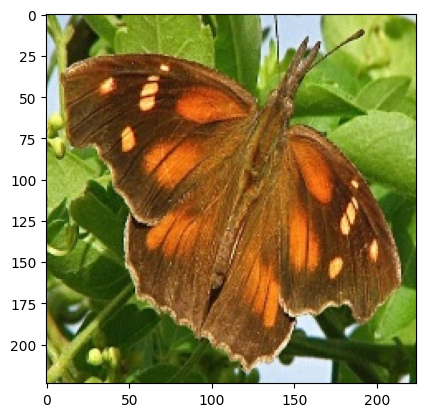

In [ ]:
path = "/content/drive/MyDrive/butterfly_data/test/AMERICAN SNOOT/1.jpg"
img = Image.open(path)
img_array = np.array(img)
print(f"Image Shape = {img_array.shape}")
plt.imshow(img)
plt.show()

***observe some images with their labels.***

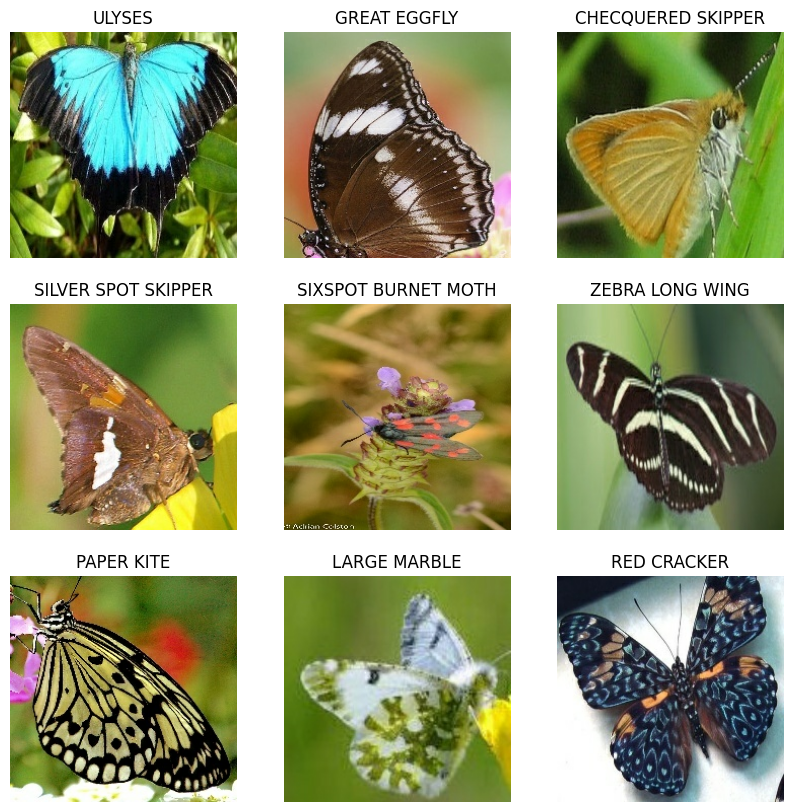

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(12, 9)):  # Limit to 9 images to fit in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ***Preprocessing***

# ***Data Augmentation***

***use Autotune algorithm for fetching the training images.***

***This will improve the model training efficiency for both MobileNet and Inception-Resnet architecture.***

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # is a constant that indicates TensorFlow should dynamically adjust the value based on the available system resources to improve data loading performance.
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #  you're allowing TensorFlow to automatically determine the optimal buffer size for prefetching based on the current hardware and system conditions

   **Create a Sequential model composed of 2 layers**
   
   **Returns:**
    
   **tf.keras.Sequential**

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomContrast(0.10))
    data_augmentation.add(RandomZoom(0.12))

    return data_augmentation

# ***Test Augmentation***

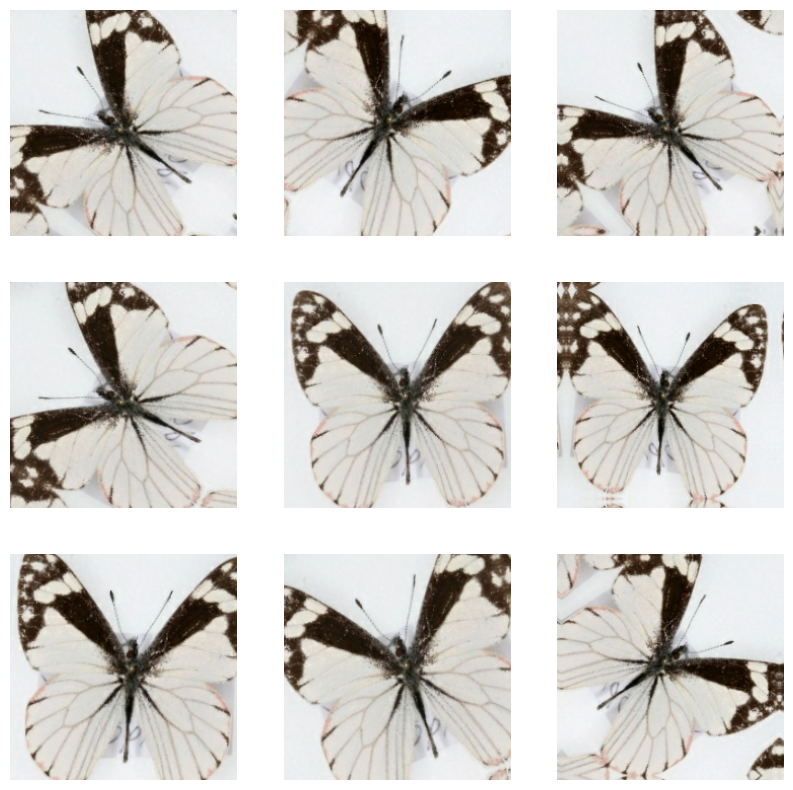

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# ***Model Creation and Training***

***Mobilenet V2 model and Inception-Resnet model.***

# ***1.1 MobileNet V2***

In [ ]:
#This step is important as models stored in tensorflow has specific additional preprocessing steps
preprocessed_input_MobileNet = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
#Importing MobileNet V2 while removing the top layers
pretrained_MobileNet = tf.keras.applications.MobileNetV2(
    input_shape= (224, 224, 3),
    include_top=False,  # Drop imagenet classifier on the top
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# ***use functional API to create a model using our own preprocessing and base_mnet***

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocessed_input_MobileNet(x)
x = pretrained_MobileNet(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate= 0.2)(x)

outputs = keras.layers.Dense(units= 120, activation='linear')(x)

MobileNet_model = tf.keras.Model(inputs,outputs)
MobileNet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 2,377,592 (9.07 MB)

 Non-trainable params: 34,112 (133.25 KB)

# ***fine-tune a MobileNet model by making specific layers trainable***

In [ ]:
# Assuming you want to fine-tune the pretrained MobileNet model (pretrained_MobileNet)
# not the entire MobileNet_model which includes augmentation and the dense layer.

# You can access the pretrained MobileNet model directly
MobileNet_tune = pretrained_MobileNet

# Then set the trainable property for its layers
MobileNet_tune.trainable = True
print("Number of layers in the base Mnet model: ", len(MobileNet_tune.layers))

Number of layers in the base Mnet model:  154


In [ ]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
# We will train the layers from fine_tine_at

for layer in MobileNet_tune.layers[:fine_tune_at]:
    layer.trainable = False

# ***Compile***

In [ ]:
# to improve performance
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

MobileNet_model.compile(loss = loss_function,
              optimizer = Adam(learning_rate = 0.0001), #Using a smaller learning rate
              metrics = ['accuracy'])

In [ ]:
#Checking that trianable has been apploed properly
print(MobileNet_tune.layers[99].trainable)
print(MobileNet_tune.layers[100].trainable)

False
True


In [ ]:
MobileNet_history = MobileNet_model.fit(train_dataset,epochs=10,validation_data=validate_dataset)

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1974s 5s/step - accuracy: 0.3888 - loss: 3.0178 - val_accuracy: 0.7800 - val_loss: 0.8142
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1032s 3s/step - accuracy: 0.8735 - loss: 0.5161 - val_accuracy: 0.8940 - val_loss: 0.4080
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1025s 2s/step - accuracy: 0.9138 - loss: 0.3329 - val_accuracy: 0.9460 - val_loss: 0.2370
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1007s 3s/step - accuracy: 0.9363 - loss: 0.2401 - val_accuracy: 0.9600 - val_loss: 0.2060
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - accuracy: 0.9499 - loss: 0.1932 - val_accuracy: 0.9460 - val_loss: 0.2103
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 1040s 2s/step - accuracy: 0.9551 - loss: 0.1621 - val_accuracy: 0.9560 - val_loss: 0.1973
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.9623 - loss: 0.1333 - val_accuracy: 0.9660 - val_loss: 0.1852
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 998s 3s/step - accuracy: 0.9720 - loss: 0.1037 - va

# ***Model Evaluation***

MobileNet V2 Training Accuracy: 0.9776439070701599
MobileNet V2 Validation Accuracy: 0.9539999961853027
MobileNet V2 Training Loss: 0.07931119948625565
MobileNet V2 Validation Loss: 0.19569963216781616


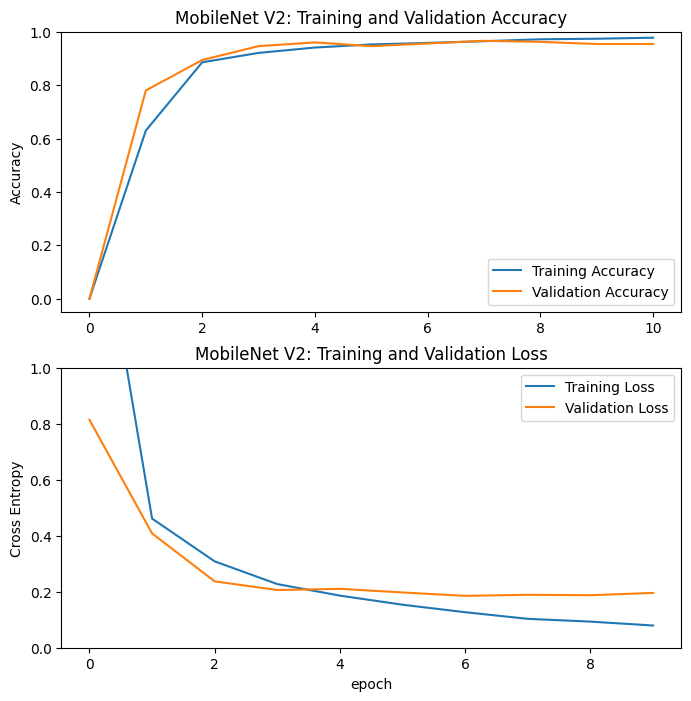

In [ ]:
acc = [0.] + MobileNet_history.history['accuracy']
print('MobileNet V2 Training Accuracy:', acc[-1])
val_acc = [0.] + MobileNet_history.history['val_accuracy']
print('MobileNet V2 Validation Accuracy:', val_acc[-1])

loss = MobileNet_history.history['loss']
print('MobileNet V2 Training Loss:', loss[-1])
val_loss = MobileNet_history.history['val_loss']
print('MobileNet V2 Validation Loss:', val_loss[-1])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('MobileNet V2: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('MobileNet V2: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_loss_mnet, test_accuracy_mnet = MobileNet_model.evaluate(validate_dataset)
print('MobileNe t V2Test Loss:', test_loss_mnet)
print('MobileNet V2 Test Accuracy:', test_accuracy_mnet)

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9538 - loss: 0.2091
MobileNet V2 Test Loss: 0.19569964706897736
MobileNet V2 Test Accuracy: 0.9539999961853027


# ***Test the model***

In [ ]:
# Save the trained model
MobileNet_model.save('butterfly_classification_model.keras')

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('butterfly_classification_model.keras')

# Get the class labels from the training dataset
class_labels = class_names

# # Initialize an empty list to store predictions
predictions = []

# Iterate through the images in the test dataset and make predictions
for image_batch, label_batch in test_dataset:
    predicted_probs = loaded_model.predict(image_batch)
    predicted_labels = [class_labels[np.argmax(prob)] for prob in predicted_probs]
    predictions.extend(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 123,
    image_size=(img_height,img_width),
    shuffle=False
)

Found 500 files belonging to 100 classes.


In [ ]:
predictions = loaded_model.predict(test_dataset)
score = tf.nn.softmax(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


In [ ]:
result = loaded_model.evaluate(test_dataset)
print("Test loss, test accuracy:", result)

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9635 - loss: 0.1337
Test loss, test accuracy: [0.13284996151924133, 0.9639999866485596]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
y_test = np.concatenate(test_labels)
y_pred = np.array([np.argmax(s) for s in score])

print(classification_report(y_test, y_pred, target_names=class_names))

                           precision    recall  f1-score   support

                   ADONIS       0.83      1.00      0.91         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.60      0.75         5
            BECKERS WHITE       0.83      1.00      0.91         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
         BLACK HAIRSTREAK       1.00      1.00      1.00     

In [ ]:
MobileNet_model.save('/content/drive/MyDrive/butterfly_model.h5')

In [ ]:
import os
os.path.exists('/content/drive/MyDrive/butterfly_model.h5')

True

In [ ]:
!cp /content/drive/MyDrive/butterfly_model.h5 butterfly_model.h5
